# Generic imports and helper functions

In [1]:
%reset -f
import gym
import numpy as np
from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline
import torch

import torch.nn as nn
import torch.nn.functional as F
import copy
import random

from collections import deque
import sys

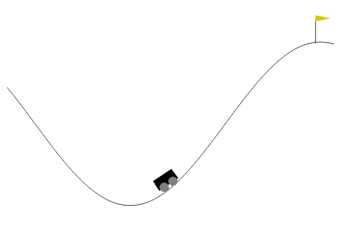

In [3]:
def test_env(env: gym.Env) -> None:
    env.reset()
    done = False
    img = plt.imshow(env.render(mode='rgb_array')) 
    i = 0
    while not done:
        _, _, done, _ = env.step(env.action_space.sample())
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)

env = gym.make('MountainCar-v0')
test_env(env)

In [4]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def reset(self):
        obs = self.env.reset()
        return torch.from_numpy(obs).unsqueeze(dim=0).float()
    
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

# Mountain Car

In [5]:
# env = gym.make('MountainCar-v0')
# test_env(env)
# env.close()

In [6]:
env = gym.make('MountainCar-v0')
env = PreprocessEnv(env)

state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n

In [7]:
class  MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.mainLayer = nn.Sequential(
            nn.Linear(state_dims, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_actions)
        )
    def forward(self, x):
        x = self.mainLayer(x)
        return x

# test model
model = MyModel()
state = env.reset()
print(state.shape)
model(state).shape

torch.Size([1, 2])


torch.Size([1, 3])

In [8]:
model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.99
epsilon = 0.3

In [10]:
epochs = 1001
losses = []
mem_size = 20000
batch_size = 5000
replay = deque(maxlen=mem_size)
sync_freq = 5000
j = 0
for i in range(epochs):
    state1 = env.reset()
    done = False

    while not done:
        qval = model(state1)
        qval_ = qval.data.numpy()
        action = np.argmax(qval_) if random.random() < epsilon else np.random.randint(0,2)
        print
        state2, reward, done, _ = env.step(torch.tensor(action))
        exp = (state1, action, reward, state2, done)
        replay.append(exp)
        state1 = state2
        
        if len(replay) > batch_size:
            j += 1
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.stack([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.stack([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])  
            Q1 = model(state1_batch)
            with torch.no_grad():
                Q2 = model2(state2_batch)
            Y = reward_batch + gamma*((1-done_batch)*torch.max(Q2,dim=2)[0][0])
            #X = Q1.gather(dim=2, index=action_batch.long().unsqueeze(dim=0)).squeeze()
            X = Q1.gather(dim=2, index=action_batch.long().unsqueeze(dim=-1).unsqueeze(dim=-1)).squeeze()
            loss = loss_fn(X,Y.detach())
            # print(i,loss.item())
            # clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()      
        
        
            if j % sync_freq == 0:
                model2.load_state_dict(model.state_dict())
    if i %100 == 0:
        torch.save(model, "savedModels/mountainCar/mc_"+str(i) +".pth")
#losses = np.array(losses)
print("done")

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

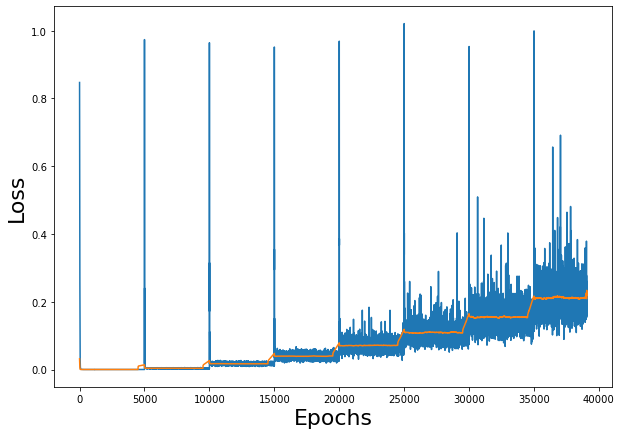

In [11]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.plot([np.mean(losses[i:i+500]) for i in range(len(losses))])
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

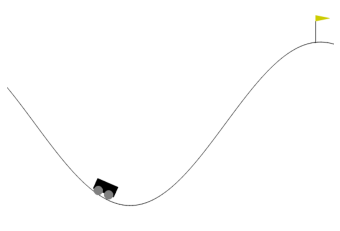

In [128]:
# Test the agent

def test_model() -> None:
    state = env.reset()
    done = False
    img = plt.imshow(env.render(mode='rgb_array')) 
    while not done:
        qval = model2(state)
        qval_ = qval.data.numpy()
        action = np.argmax(qval_)
        state, reward, done, _ = env.step(torch.tensor(action))
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)

test_model()

3

# TODO: Deep SARSA Cartpole

# TODO: Deep SARSA double pendulum